# Maritime Inventory Routing Problem (Two-Stage)
## First stage
### Speed is fixed to operating speed


# Vi gjør følgende:

1. Genererer kun service speed arcs.
    * Løser MIRP med dette.
    * Lagrer rutene for hver vessel
    * Fikserer denne ruten, dvs sekvensen av portene skal være like
    
2. Optimerer så hastigheten, samtidig som denne sekvensen av porter er de samme for hver vessel
    * Må fortsatt huske på at Berth-limit skal overholdes.

In [43]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import csv
import networkx as nx
import matplotlib.pyplot as plt
import math


In [44]:
m = gp.Model('Maritime Inventory Routing Problem, operating speed')

# Creating classes in order organize the code

In [45]:
class Port:
    def __init__(self, capacity, inventory, rate, price, berth_limit, port_fee, max_amount, min_amount, number, isLoadingPort):
        self.capacity = capacity
        self.inventory = inventory
        self.rate = rate
        self.price = price 
        self.berth_limit = berth_limit 
        self.port_fee = port_fee
        self.max_amount = max_amount
        self.min_amount = min_amount
        self.number = number
        self.isLoadingPort = isLoadingPort
        
    def __repr__(self):
        return f'Port {self.number}'
    
    def __repr2__(self):
        return f'Port {self.number}: Capacity = {self.capacity}, Inventory = {self.inventory}, Rate = {self.rate}, Price = {self.price}, Berth Limit = {self.berth_limit}, Port Fee = {self.port_fee}, Max Amount = {self.max_amount}, Min Amount = {self.min_amount}, is Loading Port = {self.isLoadingPort}'
        
    

class Node:
    def __init__(self, port, time):
        self.port = port
        self.time = time
        self.tuple = (port.number if port else None, time)
        self.incoming_arcs = set()
        self.outgoing_arcs = set()
        self.berths = port.berth_limit if port else None
    
    def __repr__(self):
        return str(self.tuple)


class Arc:
    def __init__(self, origin_node, destination_node, distance, cost, travel_time, speed, is_waiting_arc):
        self.origin_node = origin_node
        self.destination_node = destination_node
        self.tuple = (origin_node, destination_node)
        self.distance = distance
        self.cost = cost
        self.travel_time = travel_time
        self.speed = speed
        self.is_waiting_arc = is_waiting_arc
            
    def __repr__(self):
        return f'{self.origin_node} -> {self.destination_node} --- Cost: {self.cost} --- Speed: {self.speed}'

class Vessel:
    def __init__(self, max_inventory, initial_inventory, max_operating_quantity, number):
        self.max_inventory = int(max_inventory)
        self.inventory = initial_inventory
        self.max_operating_quantity = max_operating_quantity
        self.number = number
        self.arcs = set()
        self.all_arcs_v = set()
        
    def __repr__(self):
        return f'Vessel {self.number}'

    def __repr2__(self):
        return f'Vessel {self.number}: Max Inventory = {self.max_inventory}, Inventory = {self.inventory}, Max Operating Quantity = {self.max_operating_quantity}'
        

### Read in file

In [46]:
# Read the content of the provided file
with open("data/LR1_1_DR1_3_VC1_V7a.txt", 'r') as file:
    content = file.read()

In [47]:
def parse_metadata(content):
    metadata = {}
    
    # Extract lines between "----- MetaData -----" and the next section separator (empty line or end of file)
    start_index = content.index("----- MetaData -----") + len("----- MetaData -----")
    end_index = content.find("\n\n", start_index) if "\n\n" in content[start_index:] else len(content)
    metadata_section = content[start_index:end_index].strip().split("\n")
    
    for line in metadata_section:
        if ":" in line:
            # Split the line at ":" to extract the key and value
            key, value = line.split(":")
            # Store the key-value pair in the dictionary
            metadata[key.strip()] = value.strip()
    
    return metadata

## Read in metadata

In [48]:
'''Are not using these values:
    spotMarketPricePerUnit = float(metadata['spotMarketPricePerUnit'])
    spotMarketDiscountFactor = float(metadata['spotMarketDiscountFactor'])
    perPeriodRewardForFinishingEarly = float(metadata.get('perPeriodRewardForFinishingEarly', 0))
    attemptCost = float(metadata.get('attemptCost', 0))
    constantForSinglePeriodAlphaSlack = float(metadata.get('constantForSinglePeriodAlphaSlack', 0))
    constantForCumulativeAlphaSlack = float(metadata.get('constantForCumulativeAlphaSlack', 0))'''

def read_and_assign_metadata_from_content(content):
    # Parse the metadata
    metadata = parse_metadata(content)
    
    # Assign the metadata values to variables
    numPeriods = int(metadata['numPeriods'].split()[-1])  # Extract the last word (number) from the string
    numCommodities = int(metadata['numCommodities'])
    numLoadingRegions = int(metadata['numLoadingRegions'])
    numDischargingRegions = int(metadata['numDischargingRegions'])
    numLoadingPortsInRegion = [int(x) for x in metadata['numLoadingPortsInRegion'][1:-1].split()]
    numDischargingPortsInRegion = [int(x) for x in metadata['numDischargingPortsInRegion'][1:-1].split()]
    numVesselClasses = int(metadata['numVesselClasses'])
    numTermVesselsInClass = [int(x) for x in metadata['numTermVesselsInClass'][1:-1].split()]
    hoursPerPeriod = int(metadata['hoursPerPeriod'])
    spotMarketPricePerUnit = float(metadata['spotMarketPricePerUnit'])
    spotMarketDiscountFactor = float(metadata['spotMarketDiscountFactor'])
    perPeriodRewardForFinishingEarly = float(metadata.get('perPeriodRewardForFinishingEarly', 0))
    attemptCost = float(metadata.get('attemptCost', 0))
    constantForSinglePeriodAlphaSlack = float(metadata.get('constantForSinglePeriodAlphaSlack', 0))
    constantForCumulativeAlphaSlack = float(metadata.get('constantForCumulativeAlphaSlack', 0))
    
    # Return the assigned variables
    return {
        'numPeriods': numPeriods,
        'numCommodities': numCommodities,
        'numLoadingRegions': numLoadingRegions,
        'numDischargingRegions': numDischargingRegions,
        'numLoadingPortsInRegion': numLoadingPortsInRegion,
        'numDischargingPortsInRegion': numDischargingPortsInRegion,
        'numVesselClasses': numVesselClasses,
        'numTermVesselsInClass': numTermVesselsInClass,
        'hoursPerPeriod': hoursPerPeriod,
        'spotMarketPricePerUnit': spotMarketPricePerUnit,
        'spotMarketDiscountFactor': spotMarketDiscountFactor,
        'perPeriodRewardForFinishingEarly': perPeriodRewardForFinishingEarly,
        'attemptCost': attemptCost,
        'constantForSinglePeriodAlphaSlack': constantForSinglePeriodAlphaSlack,
        'constantForCumulativeAlphaSlack': constantForCumulativeAlphaSlack}

In [49]:

# Using the refactored function with the already-read content
metadata_from_content = read_and_assign_metadata_from_content(content)
# Change the numPeriods manually.

ORIGINAL_NUM_TIME_PERIODS = metadata_from_content['numPeriods']

### Read in port data

In [50]:
def parse_region_table(content):
    # Extract the region table section
    start_index = content.index("----- Region Table ----") + len("----- Region Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    region_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    regions = {}
    for line in region_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            regions[attribute] = values
    return regions


def parse_port_table_for_region(content, region_index):
    # Extract the port table section for the specified region
    search_str = f"----- Port Table For Region {region_index} ----"
    start_index = content.index(search_str) + len(search_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    port_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    ports = {}
    for line in port_section:
        attribute, *values = line.split()
        ports[attribute] = values
    return ports


In [51]:
# Extract region and port information
regions_info = parse_region_table(content)
ports_info = {f"Region {i}": parse_port_table_for_region(content, i) for i in range(len(regions_info['NumPorts']))}
ports_info

{'Region 0': {'Capacity': ['594'],
  'Inventory': ['297'],
  'Rate': ['99'],
  'Price': [],
  'BerthLimit': ['1'],
  'PortFee': ['38'],
  'maxAmt': ['300'],
  'minAmt': ['35'],
  'C2R': ['ratio', '6']},
 'Region 1': {'Capacity': ['351', '510', '312'],
  'Inventory': ['168', '255', '156'],
  'Rate': ['-39', '-34', '-26'],
  'Price': ['5', '5', '5'],
  'BerthLimit': ['1', '1', '1'],
  'PortFee': ['57', '58', '66'],
  'maxAmt': ['300', '300', '259'],
  'minAmt': ['50', '35', '20'],
  'C2R': ['ratio', '9', '15', '12']}}

### Create the ports

In [52]:
def create_ports_from_info_with_loading(ports_info):
    all_ports = {}
    tot_num = 1
    
    for region_idx, (region, port_attributes) in enumerate(ports_info.items()):
        region_ports = []
        for i in range(len(port_attributes['Capacity'])):
            port = Port(
                capacity=int(port_attributes['Capacity'][i]) if 'Capacity' in port_attributes else None,
                inventory=int(port_attributes['Inventory'][i]) if 'Inventory' in port_attributes else None,
                rate=abs(int(port_attributes['Rate'][i])) if 'Rate' in port_attributes else None,
                price=int(port_attributes['Price'][i]) if 'Price' in port_attributes and port_attributes['Price'] else None,
                berth_limit=int(port_attributes['BerthLimit'][i]) if 'BerthLimit' in port_attributes else None,
                port_fee=int(port_attributes['PortFee'][i]) if 'PortFee' in port_attributes else None,
                max_amount=int(port_attributes['maxAmt'][i]) if 'maxAmt' in port_attributes else None,
                min_amount=int(port_attributes['minAmt'][i]) if 'minAmt' in port_attributes else None,
                number=int(tot_num),  # Using 1 to numports+1 as the port number
                isLoadingPort=1 if region_idx == 0 else -1)  # Set loadingPort to True if the region is the first one
            region_ports.append(port)
            tot_num += 1
        all_ports[region] = region_ports
    return all_ports

In [53]:
all_ports = create_ports_from_info_with_loading(ports_info)

In [54]:
# Create a list of all ports
ports = []
for region, region_ports in all_ports.items():
    ports.extend(region_ports)
ports

[Port 1, Port 2, Port 3, Port 4]

# Initial Parameters

All parameters should be set below

In [55]:
# Time periods
NUM_TIME_PERIODS = 62
metadata_from_content['numPeriods'] = NUM_TIME_PERIODS
TIME_PERIOD_RANGE = list(range(1, NUM_TIME_PERIODS+1))

# Number of vessels
ORIGINAL_NUM_VESSELS = metadata_from_content['numTermVesselsInClass'][0]
NUM_VESSELS = 2

# Speed interval
MAX_SPEED = 15
MIN_SPEED = 8
OPERATING_SPEED = 14

# Operating cost
OPERATING_COST = 200

# Waiting cost
WAITING_COST = 50

# Fuel price in USD per ton
FUEL_PRICE = 500

#Numper of ports
NUM_PORTS = len(ports)


In [56]:
def parse_vessel_table(content):
    # Extract the vessel table section
    start_index = content.index("----- Vessel Table ----") + len("----- Vessel Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    vessel_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    
    vessels = {}
    for line in vessel_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            vessels[attribute] = values
    return vessels

In [57]:
# Extract vessel information
vessels_info = parse_vessel_table(content)
vessels_info

{'Type': ['Term', 'Term', 'Term', 'Term', 'Term', 'Term', 'Term'],
 'Class': ['0', '0', '0', '0', '0', '0', '0'],
 'Capacity': ['300', '300', '300', '300', '300', '300', '300']}

In [58]:
# Create a dictionary with key = vessel class and value = vessel object
vessels = {}
tot = 1
for vessel_class in range(metadata_from_content['numVesselClasses']):
    vessel_list = []
    vessels_in_class = metadata_from_content['numTermVesselsInClass'][vessel_class]
    for i in range(vessels_in_class):
        vessel_list.append(Vessel(
            max_inventory=int(vessels_info['Capacity'][i]),
            initial_inventory=int(0),
            max_operating_quantity=int(vessels_info['Capacity'][i]),
            number=tot
        ))
        tot += 1
    vessels[vessel_class] = vessel_list

# We only have one vessel class. Convert the dictionary to a list
vessels = vessels[0]
vessels


[Vessel 1, Vessel 2, Vessel 3, Vessel 4, Vessel 5, Vessel 6, Vessel 7]

In [59]:
# Manually set the number of vessels
vessels = vessels[:NUM_VESSELS]
vessels

[Vessel 1, Vessel 2]

### Creating the nodes

In [60]:
# Create the regular nodes
regularNodes = []
for t in range(1, NUM_TIME_PERIODS+1):
    for port in ports:
        node = Node(port=port, time=t)
        regularNodes.append(node)
    
# Create fictional source and sink port
sourcePort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=0, isLoadingPort=True)
sinkPort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=len(ports)+1, isLoadingPort=False)

# Create source and sink node
sourceNode = Node(port=sourcePort, time=0)
sinkNode = Node(port=sinkPort, time=NUM_TIME_PERIODS+1)

NODES = [sourceNode] + regularNodes + [sinkNode]

# Create a node dictionary with key = (port, time) tuple and value = node object
NODE_DICT = {}
for node in NODES:
    NODE_DICT[node.tuple] = node

### Read in arc data

In [61]:
def parse_full_distance_matrix(content):
    # Extract the full distance matrix section
    start_str = "----- FullDistanceMatrix ----"
    start_index = content.index(start_str) + len(start_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    matrix_section = content[start_index:end_index].strip().split("\n")[2:]  # Exclude the header lines
    
    # Convert the matrix section to a 2D list of distances
    distances = []
    for line in matrix_section:
        try:
            distance_row = list(map(float, line.split()[1:]))  # Excluding the leading port number
            distances.append(distance_row)
        except ValueError:
            continue
    
    return distances

# Extracting the full distance matrix from the file content
full_distance_matrix = parse_full_distance_matrix(content)
full_distance_matrix


[[0.0, 5792.83, 5730.94, 5663.71],
 [5792.83, 0.0, 326.1, 338.92],
 [5730.94, 326.1, 0.0, 67.42],
 [5663.71, 338.92, 67.42, 0.0]]

In [62]:
# Scale factor
SCALE_FACTOR = 0.25

# Scaling the first row
scaled_distance_matrix = [[x * SCALE_FACTOR for x in full_distance_matrix[0]]]

# Scaling the first column of the rest of the rows and preserving the other elements
scaled_distance_matrix.extend(
    [[row[0] * SCALE_FACTOR] + row[1:] for row in full_distance_matrix[1:]]
)

FULL_DISTANCE_MATRIX = scaled_distance_matrix

FULL_DISTANCE_MATRIX


[[0.0, 1448.2075, 1432.735, 1415.9275],
 [1448.2075, 0.0, 326.1, 338.92],
 [1432.735, 326.1, 0.0, 67.42],
 [1415.9275, 338.92, 67.42, 0.0]]

In [63]:
# full_distance_matrix =[[0.0, 500, 750, 800],
#  [500, 0.0, 326.1, 338.92],
#  [750, 326.1, 0.0, 67.42],
#  [800, 338.92, 67.42, 0.0]]

In [64]:
# Convert full_distance_matrix from km to nautical miles
# 1 nautical mile = 1.852 km
def km_to_nautical_miles(km):
    return km / 1.852

In [65]:
def convert_matrix_to_nautical_miles(matrix):
    return [[km_to_nautical_miles(distance) for distance in row] for row in matrix]

In [66]:
full_distance_matrix_nm = convert_matrix_to_nautical_miles(FULL_DISTANCE_MATRIX)
full_distance_matrix_nm

[[0.0, 781.9694924406047, 773.615010799136, 764.539686825054],
 [781.9694924406047, 0.0, 176.07991360691145, 183.00215982721383],
 [773.615010799136, 176.07991360691145, 0.0, 36.40388768898488],
 [764.539686825054, 183.00215982721383, 36.40388768898488, 0.0]]

In [67]:
def fuel_consumption_speed_nm(speed, nautical_miles):
    """
    Calculate the fuel consumption based on speed and nautical miles.

    Args:
    - speed (float): Speed of the vessel in knots.
    - nautical miles (float): .

    Returns:
    - float: Fuel consumption in tons.
    """
    return  (0.15*14 * (speed / 14) ** 3) * nautical_miles/speed
    

def calc_cost(fuel_consumption):
    """
    Calculate the cost based on fuel consumption.

    Args:
    - fuel_consumption (float): Fuel consumption in tons.

    Returns:
    - float: Cost in USD.
    """
    return fuel_consumption * FUEL_PRICE

# Function to calculate discrete max speed based on distance and global max speed
def calculate_minimum_timesteps_and_speed(distance_nm):
    """
    Determine the minimum timesteps and speed based on distance and max speed.

    Args:
    - distance_nm (float): Distance in nautical miles.
    - MAX_SPEED (float): Maximum speed in knots.
    - MIN_SPEED (float): Minimum speed in knots.

    Returns:
    - tuple: Minimum timesteps and speed.
    """
    hours = distance_nm / MAX_SPEED
    minimum_timesteps = math.ceil(hours / 24)
    speed = distance_nm / (minimum_timesteps * 24)
    return minimum_timesteps, max(speed, MIN_SPEED)

# Function to calculate discrete max speed based on distance and global max speed
def calculate_minimum_timesteps_with_fixed_speed(distance_nm):
    """
    Determine the minimum timesteps and speed based on distance and operating speed.

    Args:
    - distance_nm (float): Distance in nautical miles.
    - operating_speed (float): Operating speed in knots.

    Returns:
    - tuple: Minimum timesteps and operating speed.
    """
    hours = distance_nm / OPERATING_SPEED
    minimum_timesteps = math.ceil(hours / 24)
    # The speed will be operating speed no matter what, but we will round up the timesteps
    return minimum_timesteps, OPERATING_SPEED
    
# Based on rounded_hours and speed calculate the next speeds
# Creates a list with all the information needed to create the arc.
def create_arc_info(speed, minimum_timesteps, departure, origin_port, destination_port, lowest_speed, distance_to_port, vessel, is_waiting_arc):
    # Create a list of tuples with the speed and the time period
    '''arc_info: (speed in knots, timesteps for sailing, time period of departure, time period of arrival, origin port, destination port, fuel_consumption)'''
    
    arrival_time = departure + minimum_timesteps
    if arrival_time > NUM_TIME_PERIODS:
        return None
    if is_waiting_arc:
        fuel_consumption = 0
        arc_info = [(speed, 1, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    else:
        fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
        arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    
        timesteps = minimum_timesteps+1
        while True:
            
            # Calculate the next speed
            speed = distance_to_port / ((timesteps)*24)
            # If the speed is lower than the lowest speed, break the loop
            if speed < lowest_speed:
                break
            fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
            arrival_time = departure + timesteps
            # Otherwise, add the speed to the list
            arc_info.append((speed, timesteps, departure, arrival_time, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc))
            # Increment the time period
            timesteps += 1
            arrival_time = departure + timesteps
            if arrival_time > NUM_TIME_PERIODS:
                break
       
    return arc_info


# Based on rounded_hours and speed calculate the next speeds
# Creates a list with all the information needed to create the arc.
def create_arc_info_fixed_speed(speed, minimum_timesteps, departure, arrival_time, origin_port, destination_port, distance_to_port, vessel, is_waiting_arc):
    # Create a list of tuples with the speed and the time period
    '''arc_info: (speed in knots, timesteps for sailing, time period of departure, time period of arrival, origin port, destination port, fuel_consumption)'''
    
    if arrival_time > NUM_TIME_PERIODS:
        return None
    if is_waiting_arc:
        fuel_consumption = 0
        arc_info = [(speed, 1, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    else:
        fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
        arc_info = [(speed, minimum_timesteps, departure, arrival_time, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
       
    return arc_info
        

### Need to have starting positions for each vessel. 
### That way we can find the earliest time a vessel can be at each port.

For now we just randomly generate distances to each of the ports, without thinking about whether it is practically possible to have these distances. 

In [68]:
# Ensure reproducibility of the random numbers
np.random.seed(0)

source_distances = {}
# Creating manual starting positions for the vessels
for vessel in vessels:
    # Create a list of the distance from the source node to each of the ports
    '''
        0.00  5792.83  5730.94  5663.71 
    1  5792.83     0.00   326.10   338.92 
    2  5730.94   326.10     0.00    67.42 
    3  5663.71   338.92    67.42     0.00 
    '''
    # Randomly generate 4 distances for each vessel
    distances = np.random.randint(1, 40, size=len(ports))
    source_distances[vessel] = distances

In [69]:
print(source_distances)
SOURCE_DISTANCES = source_distances

'''Remember to enforce the source distances to be same for all models'''

{Vessel 1: array([ 1,  4,  4, 10]), Vessel 2: array([20, 22, 37, 24])}


'Remember to enforce the source distances to be same for all models'

# Stage 1. OPERATING SPEED

In [70]:
# Use the source_distances to create a source_times dictionary
source_times = {}
for vessel, distances in source_distances.items():
    source_times[vessel] = [math.ceil((distance / OPERATING_SPEED)/24) for distance in distances] #**

In [71]:
# Create a source_fuel_consumption as well
source_fc = {}
for vessel, distances in source_distances.items():
    source_fc[vessel] = [fuel_consumption_speed_nm(speed=OPERATING_SPEED, nautical_miles=distance)for distance in distances] #**

# Generate the arcs
## Creating all source_arcs that uses operating speed

* Need one arc from the source and to each node after the first one is reached.

In [72]:
def generate_source_arc_info_fixed_speed(vessel, ports, source_distances, sourceNode):
    source_arcs_info = []
    
    for destination_port_number in ports:
        distance_nm = source_distances[vessel][destination_port_number - 1]
    
        minimum_timesteps, speed = calculate_minimum_timesteps_with_fixed_speed(distance_nm=distance_nm) #**
        
        if minimum_timesteps > NUM_TIME_PERIODS or speed > MAX_SPEED:
            continue
        
        first_arrival_time = minimum_timesteps
        arc_info_matrix = create_arc_info_fixed_speed(speed=speed, minimum_timesteps=minimum_timesteps, departure=0, arrival_time =first_arrival_time, origin_port=sourceNode.port.number, destination_port=destination_port_number, distance_to_port=distance_nm, vessel=vessel, is_waiting_arc=False)
        source_arcs_info.append(arc_info_matrix)
        
    return source_arcs_info

In [73]:
def create_arcs_for_node(node, vessels, all_port_numbers, source_times, full_distance_matrix_nm):
    node_arcs = []
    
    for vessel in vessels:
        if node.port.number in [0, len(ports) + 1]:
            continue

        start_time = source_times[vessel][node.port.number - 1]
        if node.time < start_time:
            continue

        for destination_port_number in all_port_numbers:
            if destination_port_number == node.port.number:
                # Create waiting_arc
                arc_info_matrix = create_arc_info(speed=0, minimum_timesteps=1, departure=node.time, origin_port=node.port.number, destination_port=destination_port_number, lowest_speed=0, distance_to_port=0, vessel=vessel, is_waiting_arc=True)
                node_arcs.append(arc_info_matrix)
            else:
                distance_nm = full_distance_matrix_nm[node.port.number - 1][destination_port_number - 1]
                minimum_timesteps, speed = calculate_minimum_timesteps_with_fixed_speed(distance_nm=distance_nm) #**
                arrival_time = node.time + minimum_timesteps
                
                if arrival_time < source_times[vessel][destination_port_number - 1] or arrival_time > NUM_TIME_PERIODS:
                    continue

                arc_info_matrix = create_arc_info_fixed_speed(speed=speed, minimum_timesteps=minimum_timesteps, departure=node.time, arrival_time=arrival_time, origin_port=node.port.number, destination_port=destination_port_number, distance_to_port=distance_nm, vessel=vessel, is_waiting_arc=False)
                node_arcs.append(arc_info_matrix)

    return node_arcs

In [74]:
def add_arcs_to_nodes(all_info):
    arc_dict = {}
    vessel_arcs = {}
    waiting_arcs = {}

    for sublist in all_info:
        for subsublist in sublist:
            if not subsublist:
                continue
                
            for tuple_data in subsublist:
                speed, timesteps, departure, arrival, origin_port_number, destination_port_number, fuel_consumption, distance_nm, vessel, is_waiting_arc = tuple_data
                cost = calc_cost(fuel_consumption)
                origin_node_obj = NODE_DICT.get((origin_port_number, departure))
                destination_node_obj = NODE_DICT.get((destination_port_number, arrival))

                if origin_node_obj and destination_node_obj and arrival <= NUM_TIME_PERIODS:
                    arc = Arc(origin_node=origin_node_obj, destination_node=destination_node_obj, distance=distance_nm, cost=cost + WAITING_COST, travel_time=timesteps, speed=speed, is_waiting_arc=is_waiting_arc)
                    origin_node_obj.outgoing_arcs.add(arc)
                    destination_node_obj.incoming_arcs.add(arc)
                    arc_dict[(origin_node_obj.tuple, destination_node_obj.tuple, vessel)] = arc
                    
                    if is_waiting_arc:
                        waiting_arcs.setdefault(vessel, []).append(arc)
                    vessel_arcs.setdefault(vessel, []).append(arc)

    return arc_dict, vessel_arcs, waiting_arcs

In [75]:
source_arcs_info = [generate_source_arc_info_fixed_speed(vessel, [port.number for port in ports], source_distances, sourceNode) for vessel in vessels]

all_info = source_arcs_info.copy()

for vessel in vessels:
    arcs_for_current_vessel = [create_arcs_for_node(node, [vessel], [port.number for port in ports], source_times, full_distance_matrix_nm) for node in NODE_DICT.values()]
    all_info.extend(arcs_for_current_vessel)
    
arc_dict, vessel_arcs, waiting_arcs = add_arcs_to_nodes(all_info)

In [76]:
def add_arc_to_dict(origin, destination, vessel, arc_dict, vessel_arcs):
    """Helper function to add arc to dictionaries and nodes."""
    arc = Arc(origin_node=origin, destination_node=destination, distance=0, cost=0, travel_time=0, speed=0, is_waiting_arc=False)
    origin.outgoing_arcs.add(arc)
    destination.incoming_arcs.add(arc)
    arc_dict[(origin.tuple, destination.tuple, vessel)] = arc
    vessel_arcs.setdefault(vessel, []).append(arc)
    return arc_dict, vessel_arcs

In [77]:
def create_sink_arcs(vessels, sinkNode, source_times, arc_dict, vessel_arcs):
    for vessel in vessels:
        # Arc from source node to sink node
        arc_dict, vessel_arcs = add_arc_to_dict(sourceNode, sinkNode, vessel, arc_dict, vessel_arcs)
        
        # Arcs from other nodes to sink node
        for node in NODE_DICT.values():
            if node.port.number not in [0, len(ports) + 1] and node.time >= source_times[vessel][node.port.number - 1]:
                arc_dict, vessel_arcs = add_arc_to_dict(node, sinkNode, vessel, arc_dict, vessel_arcs)
    
    return arc_dict, vessel_arcs

In [78]:
# After calling add_arcs_to_nodes:
arc_dict, vessel_arcs, waiting_arcs = add_arcs_to_nodes(all_info)

# Then call create_sink_arcs with the returned arc_dict and vessel_arcs:
arc_dict, vessel_arcs = create_sink_arcs(vessels, sinkNode, source_times, arc_dict, vessel_arcs)

## Visualize the network for a given vessel

In [79]:
def visualize_network_for_vessel(vessel, vessel_arcs, drop_sink_arcs):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    for node in NODES:
        G.add_node(str(node.tuple))

    # Add edges (arcs) to the graph
    for arc in vessel_arcs[vessel]:
        # If the arc goes to the sink node, skip it
        if drop_sink_arcs and arc.destination_node == sinkNode:
            continue
        G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple))

    # Determine NODES with incoming and outgoing arcs
    nodes_with_incoming_arcs = [node for node, degree in G.in_degree() if degree > 0]
    nodes_with_outgoing_arcs = [node for node, degree in G.out_degree() if degree > 0]

    # Create a list to hold node colors
    node_colors = []
    for node in G.nodes():
        if node in nodes_with_incoming_arcs or node in nodes_with_outgoing_arcs:
            node_colors.append('green')  # Color for nodes with arcs
        else:
            node_colors.append('skyblue')  # Default color

    # Resetting the y_offset and y_spacing
    y_offset = 10
    y_spacing = -30  # Increase vertical spacing for better clarity

    # Manually specify the positions for each node
    pos = {}

    # Manually set the position for the source and sink nodes
    # pos["(0, 0)"] = (0, 0)  # Positioning source node at leftmost, middle height
    # pos["(5, 5)"] = (5 * 10, 0)  # Positioning sink node at rightmost, middle height

    for node in NODES:
        # Skip setting position for source and sink nodes
        # if str(node.tuple) in ["(0, 0)", "(5, 5)"]:
        #     continue
        port_index = node.port.number  # Get port number to determine y-coordinate
        # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
        pos[str(node.tuple)] = (node.time * 10, port_index * y_spacing)  # Multiplying time by 10 for better horizontal spacing

    # Drawing the graph using the adjusted positions
    plt.figure(figsize=(15, 10))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Nodes and Arcs Graph")
    plt.show()

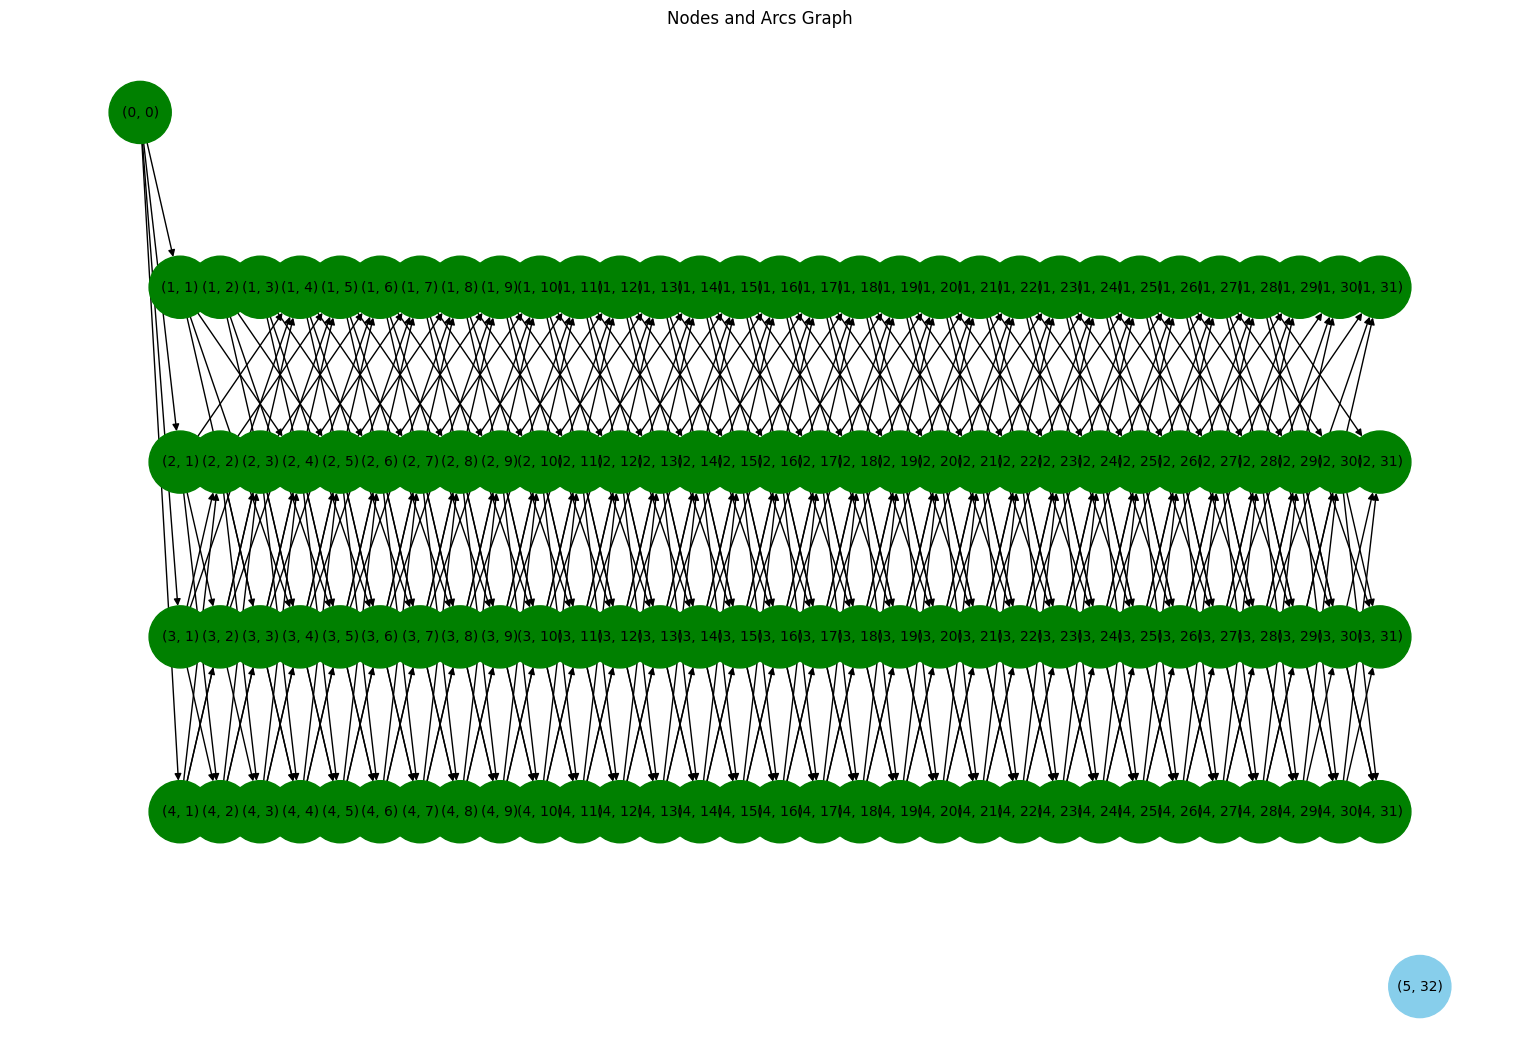

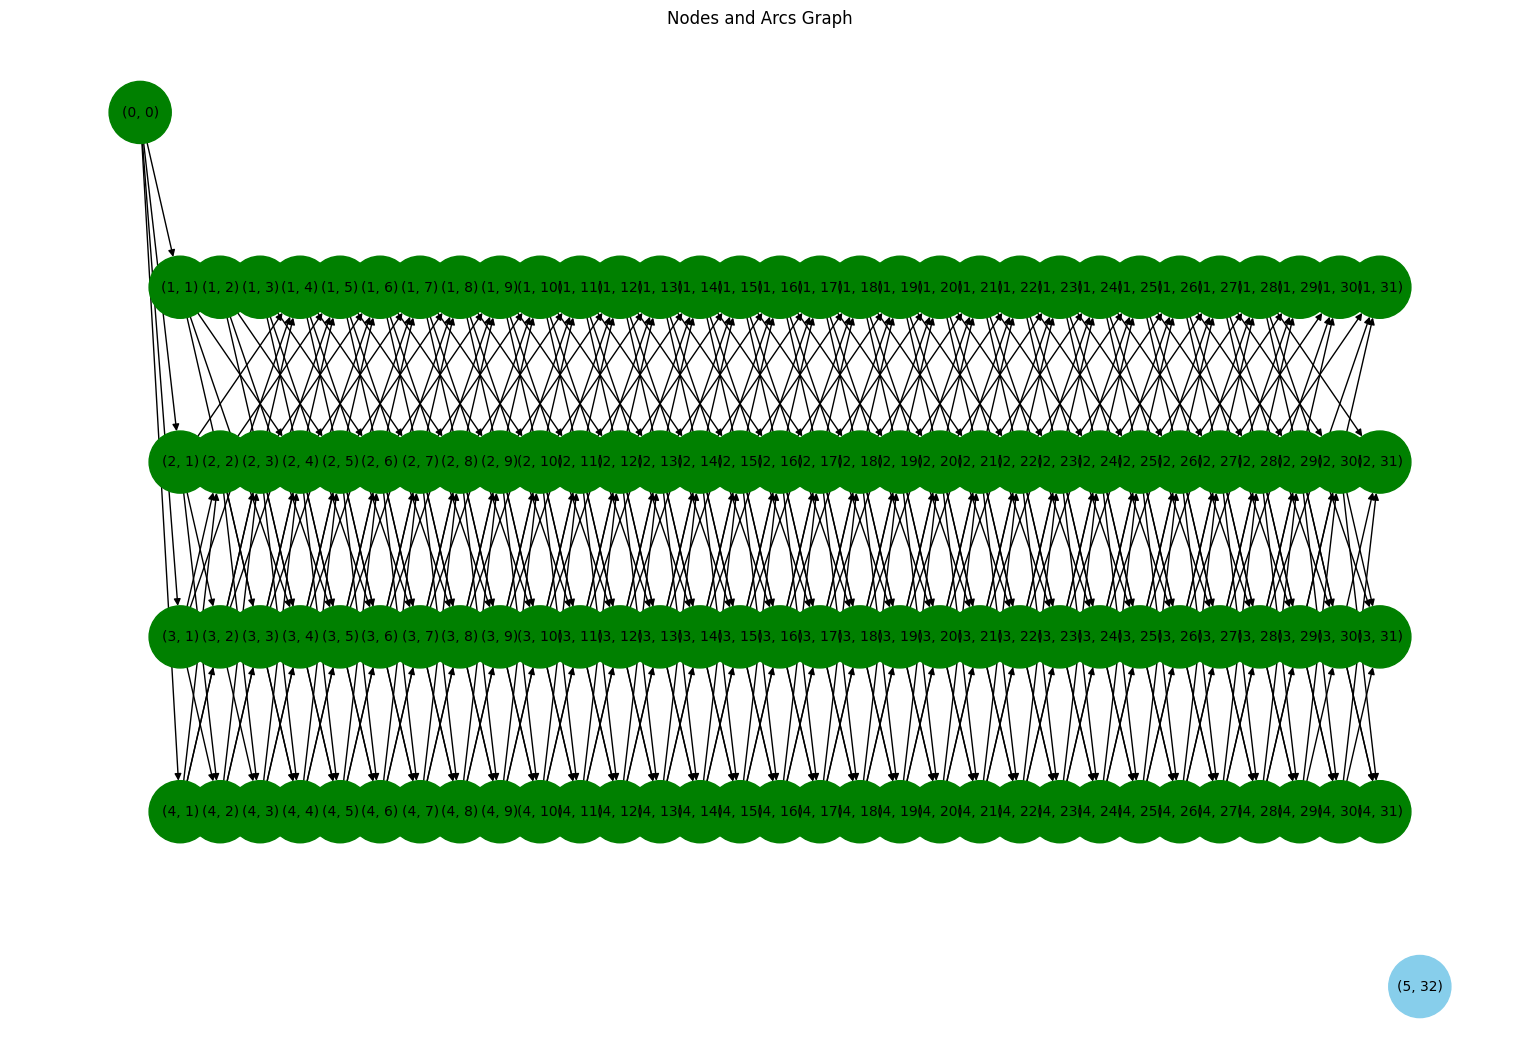

In [80]:
for v in vessels:
    visualize_network_for_vessel(v, vessel_arcs, True)

# Starting with Gurobi

In [81]:
'''Creating the variables'''
'''Binary first'''
# x is the binary variable that indicates whether a vessel travels on arc a, where and arc is a route frome one node to another node.
x = m.addVars(((arc.tuple, vessel) for vessel in vessels for arc in vessel_arcs[vessel]) , vtype=gp.GRB.BINARY, name="x")

# o is the binary variable that indicates whether vessel v is operating (loading/unloading) at node n
o = m.addVars(((node.port.number, node.time, vessel) for node in regularNodes for vessel in vessels), vtype=gp.GRB.BINARY, name="o")

'''Continuous varibles'''
# q is the amount of product loaded or unloaded at port i by vessel v at time t
q_bounds = {(node.port.number, node.time, vessel): min(vessel.max_inventory, node.port.capacity) for node in regularNodes for vessel in vessels}
q = m.addVars(q_bounds.keys(), lb=0, ub=q_bounds, vtype=gp.GRB.CONTINUOUS, name="q")

# s is the amount of product at port i at the end of period t
s_bounds = {(node.port.number, node.time): node.port.capacity for node in regularNodes}
s = m.addVars(s_bounds.keys(), lb=0, ub=s_bounds, vtype=gp.GRB.CONTINUOUS, name="s")

# Create s vars for each port in time period 0
s_bounds_source = {(port.number, 0): port.capacity for port in ports}
s_source = m.addVars(s_bounds_source.keys(), lb=0, ub=s_bounds, vtype=gp.GRB.CONTINUOUS, name="s")
s.update(s_source)

# w is the amount of product on board of vessel v at the end of time period t
w_bounds = {(t, vessel): vessel.max_inventory for vessel in vessels for t in TIME_PERIOD_RANGE}
w = m.addVars(w_bounds.keys(), lb=0, ub=w_bounds, vtype=gp.GRB.CONTINUOUS, name="w")
w_bounds_source = {(0, vessel): vessel.max_inventory for vessel in vessels}
w_source = m.addVars(w_bounds_source.keys(), lb=0, ub=w_bounds, vtype=gp.GRB.CONTINUOUS, name="w")
w.update(w_source)

m.update()

In [82]:
# Create a dict where the arc.tuple is the key and arc.cost is the value

costs = {(arc.tuple, vessel): arc.cost for vessel in vessels for arc in vessel_arcs[vessel] }
m.update()

### Objective Function

In [83]:
obj = gp.quicksum(costs[key]*x[key] for key in costs) + gp.quicksum(o[node.port.number, node.time, vessel] * OPERATING_COST for node in regularNodes for vessel in vessels)

#Minimize the costs
m.setObjective(obj, GRB.MINIMIZE)

m.update()
### Constraints

# Constraint (2)
for v in vessels:
    outgoing_from_source = [arc for arc in vessel_arcs[v] if arc.origin_node == sourceNode]
    m.addConstr(gp.quicksum((x[arc.tuple, v]) for arc in outgoing_from_source) == 1, name = 'SourceFlow')
    #m.addConstr((gp.quicksum(x[arc.tuple]) for arc in outgoing_from_source) == 1, name = 'SourceFlow')
m.update()

# Constraint (3)
for v in vessels:
    incoming_to_sink = [arc for arc in vessel_arcs[v] if arc.destination_node == sinkNode]
    m.addConstr(gp.quicksum((x[arc.tuple, v]) for arc in incoming_to_sink) == 1, name = 'SinkFlow')
    #m.addConstr((gp.quicksum(x[arc.tuple]) for arc in incoming_to_sink) == 1, name = 'SinkFlow')
m.update()

# Constraint (4)
# Creating a flow balance constraint for each node

for v in vessels:
    for node in regularNodes:
        outgoing_from_node = [arc for arc in vessel_arcs[v] if arc.origin_node == node]
        incoming_to_node = [arc for arc in vessel_arcs[v] if arc.destination_node == node]
        m.addConstr(gp.quicksum((x[in_arc.tuple, v]) for in_arc in incoming_to_node) - gp.quicksum((x[out_arc.tuple, v]) for out_arc in outgoing_from_node) == 0, name = "FlowBalance")
m.update()
        
# Constraint (5)
for port in ports:
    m.addConstr(s_source[port.number, 0] == port.inventory, name = 'InitialInventoryPort')
m.update()
    
# Constraint (6)
'''Rate is static for now'''
# Inventory balance for ports at the end of each time period t
for port in ports:
    for t in TIME_PERIOD_RANGE:
        m.addConstr(s[port.number, t] == (s[port.number, t-1] + (port.isLoadingPort * port.rate) - gp.quicksum(port.isLoadingPort * q[port.number, t, v] for v in vessels)) , name = 'InventoryBalance')
m.update()

# Constraint (7)
for v in vessels:
    m.addConstr(w_source[0, v] == v.inventory, name = 'InitialInventoryVessel')
m.update()

# Constraint (8)
# for each vessel, the inventory at the end of the time period is equal to the inventory at the beginning of the time period + the amount of product loaded/unloaded at the ports
for t in TIME_PERIOD_RANGE:
    for v in vessels:
        m.addConstr(w[t, v] == gp.quicksum(port.isLoadingPort * q[port.number, t, v] for port in ports) + w[t-1,v], name = 'VesselBalance')
m.update()

# Constraint (9)
for node in regularNodes:
    m.addConstr((gp.quicksum((o[node.port.number, node.time, v]) for v in vessels) <= node.port.berth_limit), name = 'Birth_limit_in_time_t')
m.update()

#Constraint (10)
for v in vessels:
    for node in regularNodes:
        incoming_to_node = [arc for arc in vessel_arcs[v] if arc.destination_node == node]
        m.addConstr(o[node.port.number, node.time, v] <= gp.quicksum((x[in_arc.tuple, v]) for in_arc in incoming_to_node))
m.update()

all_waiting_arcs = {}
for v in vessels:
    for arc in waiting_arcs[v]:
        origin_node = arc.origin_node
        destination_node = arc.destination_node
        all_waiting_arcs[((origin_node.port.number, origin_node.time),(destination_node.port.number, destination_node.time) , v)] = arc
        
# Constraint (11)  
for node in regularNodes:
    for v in vessels:
        if (node.port.number, node.time + 1, v) in o.keys():  # check if o for the next period exists
            
            waiting_arc_key = ((node.port.number, node.time), (node.port.number, node.time + 1), v)
            if waiting_arc_key in all_waiting_arcs.keys():
                waiting_arc = all_waiting_arcs[waiting_arc_key]
            else:
                continue
            
            actual_key = (waiting_arc.tuple, v)
            
            if actual_key in x.keys():  # check if the waiting arc exists
                m.addConstr(o[node.port.number, node.time, v] <= 
                            o[node.port.number, node.time + 1, v] + 
                            (1 - x[actual_key]),
                            name=f"Operate_or_Move_{node.port.number}_{node.time}_{v}")
m.update()

# #Constraint (12)
for v in vessels:
    for node in regularNodes:
        m.addConstr(q[node.port.number, node.time, v] <= o[node.port.number, node.time, v]*v.max_operating_quantity, name = 'Max_operating_quantity')
m.update()

In [84]:
#optimize the model
# Assuming you have a Gurobi model object named 'model' and a variable named 'arc_vars' representing the arcs
# m.setParam(gp.GRB.Param.TimeLimit, 10)

# Optimize the model
m.optimize()

# Check the status of the optimization
if m.status == gp.GRB.OPTIMAL:
    print("Optimal solution found!")

#Access the x variables in order to see which arcs are used in the optimal solution
for v in m.getVars():
    if v.x > 0:
        # print the value of the variable
       print(v.varName, v.x)
        

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1304 rows, 1882 columns and 5918 nonzeros
Model fingerprint: 0x8ad12b9a
Variable types: 440 continuous, 1442 integer (1442 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [5e+01, 6e+04]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e+00, 3e+02]
Presolve removed 54 rows and 53 columns
Presolve time: 0.06s
Presolved: 1250 rows, 1829 columns, 11533 nonzeros
Variable types: 419 continuous, 1410 integer (1410 binary)

Root relaxation: objective 4.550353e+03, 1277 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4550.35278    0  250          - 4550.35278      -     -    0s
     0 

AttributeError: Unable to retrieve attribute 'x'

# After optimization

## Need to extract the routes for the vessels

In [ ]:
# For each vessel, save the route
vessel_routes_incl_wa = {}
for vessel in vessels:
    vessel_routes_incl_wa[vessel] = []
    for arc in vessel_arcs[vessel]:
        
        if x[arc.tuple, vessel].x > 0:
            vessel_routes_incl_wa[vessel].append(arc)

In [ ]:
# Sort the arcs in each route by time
for vessel in vessels:
    vessel_routes_incl_wa[vessel] = sorted(vessel_routes_incl_wa[vessel], key=lambda x: x.origin_node.time)
    
vessel_routes_incl_wa[vessels[0]]

[(0, 0) -> (5, 11) --- Cost: 0 --- Speed: 0]

In [ ]:
# For each vessel, save the route, but only the port-sequence
vessel_routes_seq = {}
for vessel in vessels:
    vessel_routes_seq[vessel] = []
    for arc in vessel_arcs[vessel]:
        if arc in waiting_arcs[vessel]:
            continue
        if x[arc.tuple, vessel].x > 0:
            vessel_routes_seq[vessel].append(arc.destination_node.port.number)

In [ ]:
# Drop the last element in each list
for vessel in vessels:
    vessel_routes_seq[vessel] = vessel_routes_seq[vessel][:-1]


In [ ]:
vessel_routes_seq

{Vessel 1: [], Vessel 2: [1, 2, 1, 3, 4, 1]}

In [ ]:
def visualize_solution_for_vessel(vessel, nodes, vessel_arcs):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    for node in nodes:
        G.add_node(str(node.tuple))

    # Add edges (arcs) to the graph
    for arc in vessel_arcs[vessel]:
        G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple))

    # Determine nodes with incoming and outgoing arcs
    nodes_with_incoming_arcs = [node for node, degree in G.in_degree() if degree > 0]
    nodes_with_outgoing_arcs = [node for node, degree in G.out_degree() if degree > 0]

   # Create a list to hold node colors
    node_colors = []
    for node_str in G.nodes():
        port_number, time = eval(node_str)  # Extract port number and time from the node label
        o_value = o.get((port_number, time, vessel))  # Use .get() to safely access the dictionary
        if o_value and o_value.x > 0:
            node_colors.append('brown')  # Color for nodes with non-zero q values
        elif node_str in nodes_with_incoming_arcs or node_str in nodes_with_outgoing_arcs:
            node_colors.append('green')  # Color for nodes with arcs
        
        else:
            node_colors.append('skyblue')  # Default color for nodes without arcs or q values


    # Resetting the y_offset and y_spacing
    y_offset = 10
    y_spacing = -30  # Increase vertical spacing for better clarity

    # Manually specify the positions for each node
    pos = {}
    for node_str in G.nodes():
        port_number, time = eval(node_str)  # Extract port number and time from the node label
        # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
        pos[node_str] = (time * 10, port_number * y_spacing)  # Multiplying time by 10 for better horizontal spacing

    # Drawing the graph using the adjusted positions
    plt.figure(figsize=(15, 10))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(f"Nodes and Arcs Graph for {vessel}")
    plt.show()

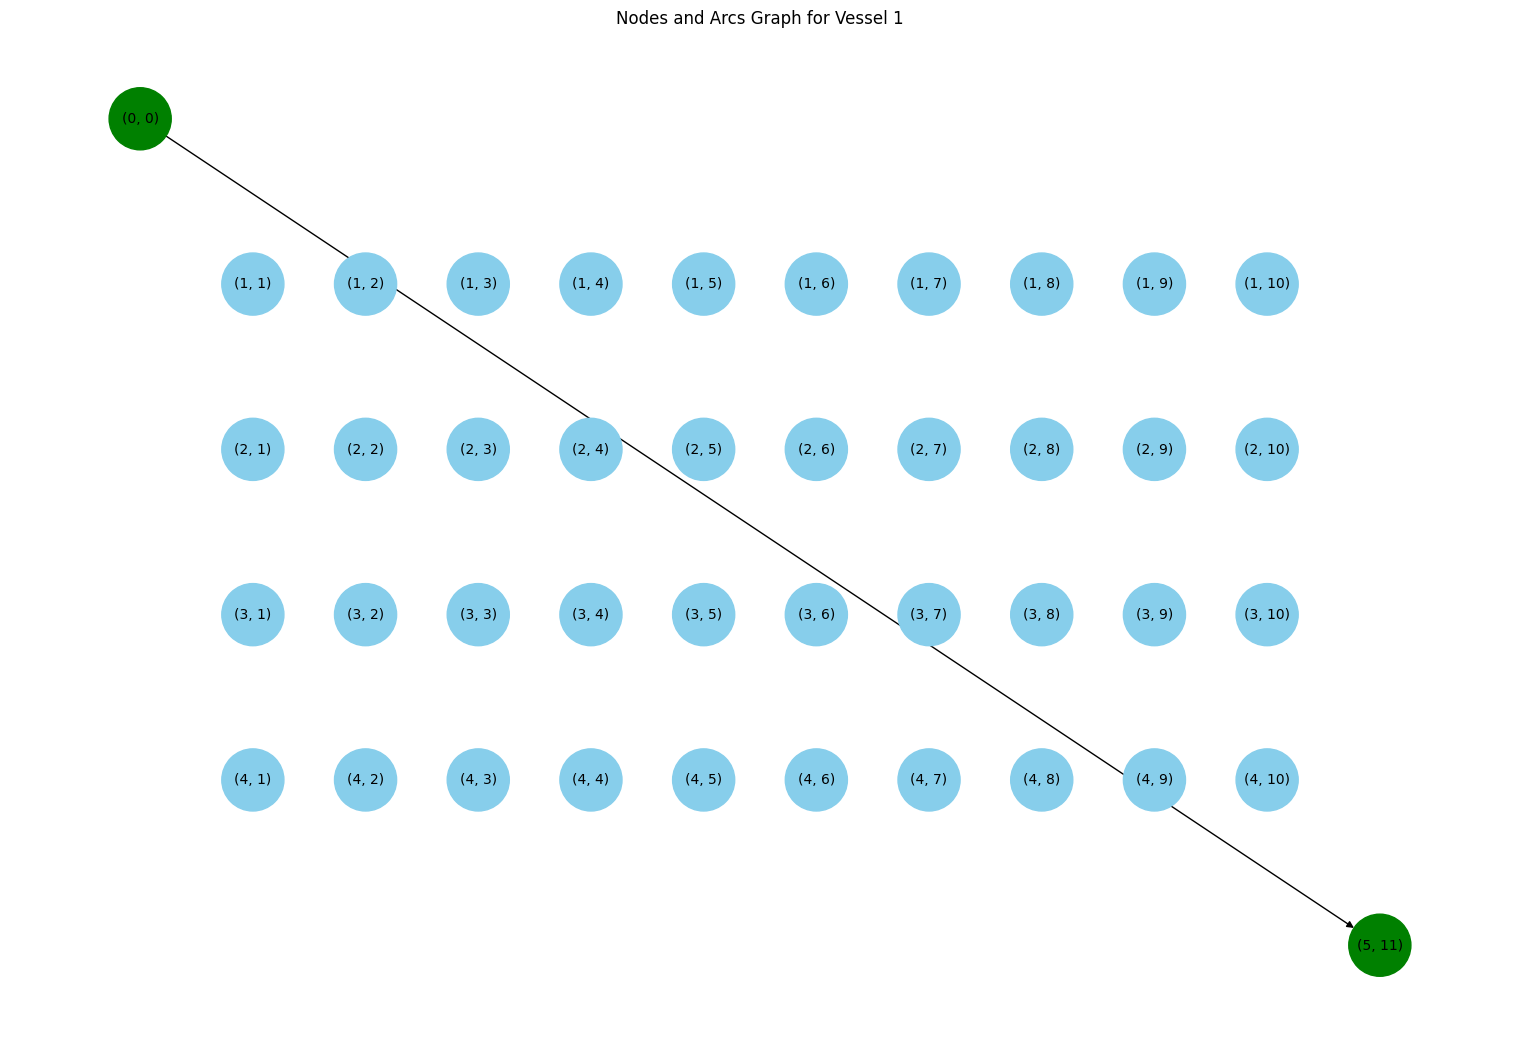

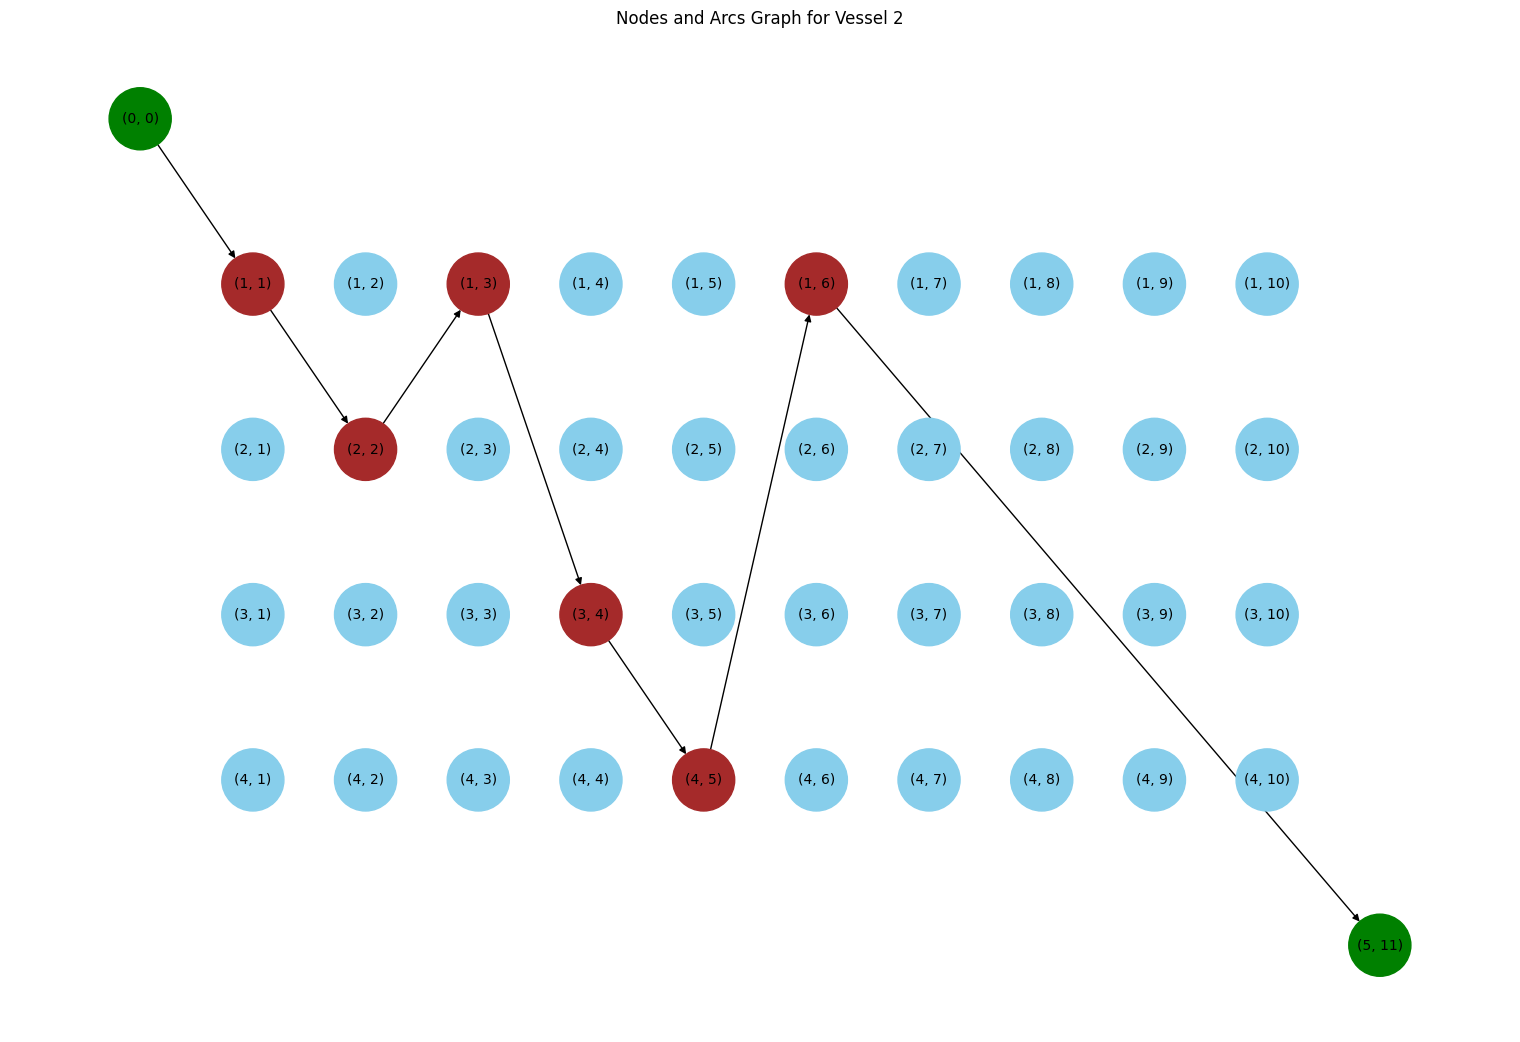

In [ ]:
for v in vessels:
    visualize_solution_for_vessel(v, NODES, vessel_routes_incl_wa)

In [ ]:
# Print the o vars
for v in vessels:
    for node in regularNodes:
        if o[node.port.number, node.time, v].x > 0:
            print(o[node.port.number, node.time, v].varName, o[node.port.number, node.time, v].x)

o[1,1,Vessel 2] 1.0
o[2,2,Vessel 2] 1.0
o[1,3,Vessel 2] 1.0
o[3,4,Vessel 2] 1.0
o[4,5,Vessel 2] 1.0
o[1,6,Vessel 2] 1.0


In [ ]:
# Do the same for q-vars
for v in vessels:
    for node in regularNodes:
        if q[node.port.number, node.time, v].x > 0:
            print(q[node.port.number, node.time, v].varName, q[node.port.number, node.time, v].x)

q[1,1,Vessel 2] 222.0
q[2,2,Vessel 2] 222.0
q[1,3,Vessel 2] 189.0
q[3,4,Vessel 2] 85.0
q[4,5,Vessel 2] 104.0
q[1,6,Vessel 2] 282.0


In [ ]:
# Open a file to write the results
with open('solutions/MIRP_operating_speed_results.txt', 'w') as file:
    
    file.write("Hyperparameters:\n")
    file.write(f"Number of Time Periods: {NUM_TIME_PERIODS}\n")
    file.write(f"Time Period Range: {TIME_PERIOD_RANGE}\n")
    file.write(f"Original Number of Vessels: {ORIGINAL_NUM_VESSELS}\n")
    file.write(f"Number of Vessels: {NUM_VESSELS}\n")
    file.write(f"Max Speed: {MAX_SPEED}\n")
    file.write(f"Min Speed: {MIN_SPEED}\n")
    file.write(f"Operating Speed: {OPERATING_SPEED}\n")
    file.write(f"Operating Cost: {OPERATING_COST}\n")
    file.write(f"Waiting Cost: {WAITING_COST}\n")
    file.write(f"Fuel Price (USD/ton): {FUEL_PRICE}\n\n")
    file.write(f"Number of ports: {NUM_PORTS}\n\n")
    
    file.write("\nPorts:\n")
    for port in ports:
        file.write(f"{port.__repr2__()}\n")
        
    file.write("\nVessels:\n")
    for vessel in vessels:
        file.write(f"{vessel.__repr2__()}\n")
    
    file.write("\nFull distance matrix:\n")
    for row in FULL_DISTANCE_MATRIX:
        row_str = ', '.join([f"{item:.4f}" for item in row])  # Format each item in the row
        file.write(f"[{row_str}]\n")
        
    file.write("\nSource Distances:\n")
    for vessel, distances in SOURCE_DISTANCES.items():
        distances_str = ', '.join(map(str, distances))  # Convert each item in the array to string and join with comma
        file.write(f"{vessel}: [{distances_str}]\n")
    
    file.write("----------------------------------------\n")
    # Write the objective value
    file.write(f"Objective Value: {m.objVal}\n")    
    file.write("----------------------------------------\n")

    # Write the values of all variables
    file.write("Variable Values:\n")
    for var in m.getVars():
        file.write(f"{var.varName}: {var.x}\n")
        
    file.close()